## Convolutional Neural Networks

---

In this notebook, we visualize the kernels and activation maps in a CNN layer.

#### note: all code moved into functions in preparation for production Python class

Using TensorFlow backend.


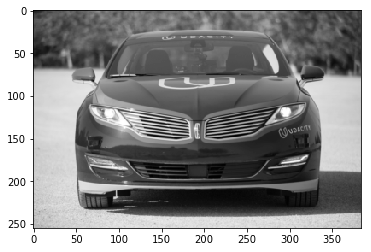

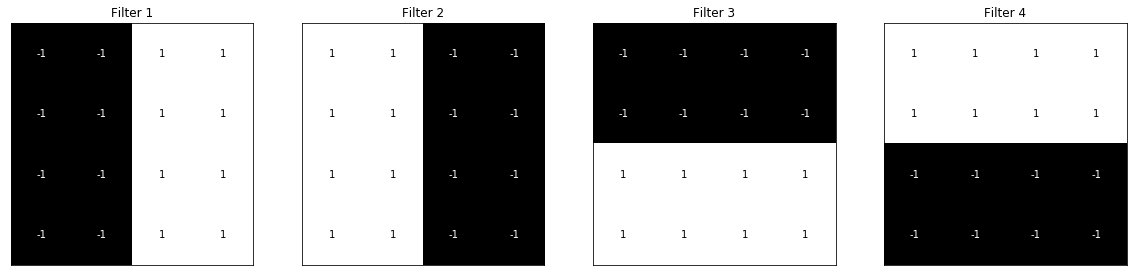

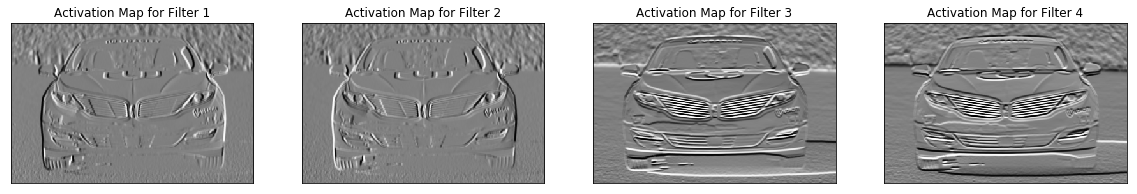

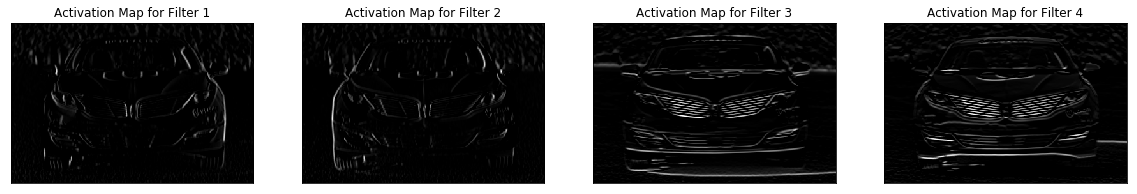

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
import numpy as np
import cv2
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

def load_image(img_path = 'images/udacity_sdc.png'):
    """
    Loads a color image and returns it as greyscale
    img_path: path to a color image file, containing a 3D tensor of shape (height, width, depth) of bytes [0-255]
    return: a 2D tensor of shape (height, width) of floats that lie in [0.0, 1.0]  
    """

    # load color image 
    bgr_img = cv2.imread(img_path)

    # convert to grayscale
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

    # resize to smaller
    small_img = scipy.misc.imresize(gray_img, 0.3)

    # rescale entries to lie in [0,1]
    small_img = small_img.astype("float32")/255
    
    return small_img


def get_model(img, kernel_size, activation):
    """
    img: a greyscale image, 2D tensor
    kernel_size: tuple
    activation: 'sigmoid', 'relu', etc
    """
    
    # define a neural network with a single convolutional layer with one kernel
    num_filters = 1
    input_height, imput_width = img.shape
    input_depth = 1
    model = Sequential()
    model.add(Convolution2D(filters=num_filters, 
                            kernel_size=kernel_size, 
                            activation=activation,
                            strides=(1,1),
                            input_shape=(input_height, imput_width, input_depth)))
    return model


def get_kernels(model):
    """
    model: convolutional network
    return: list of kernels as 2D tensors 
    """
    
    # model.layers[i].get_weights(): returns the weights of the layer i 
    # as a list of 2 Numpy arrays [kernel_weights, bias_weights].
    kernel_shape = model.layers[0].get_weights()[0].shape

    kernel_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])
    kernel_1 = kernel_vals
    kernel_2 = -kernel_1
    kernel_3 = kernel_1.T
    kernel_4 = -kernel_3
    kernels = [kernel_1, kernel_2, kernel_3, kernel_4]
    
    return kernels


def visualize_kernels(kernels):
    """
    kernels: a list of 2D tensors
    """
    fig = plt.figure(figsize=(20, 5))
    for i in range(4):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        ax.imshow(kernels[i], cmap='gray')
        ax.set_title('Filter %s' % str(i+1))
        width, height = kernels[i].shape
        for x in range(width):
            for y in range(height):
                ax.annotate(str(kernels[i][x][y]), xy=(y,x),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if kernels[i][x][y]<0 else 'black')

def visualize_activation_maps(activation_maps):
    """
    activation_maps: list of 2D tensors with values that lie in [0.0, 1.0]
    """

    fig = plt.figure(figsize=(20, 20))
    for i, activation_map in enumerate(activation_maps):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        ax.imshow(activation_map, cmap='gray')
        ax.set_title('Activation Map for Filter %s' % str(i+1))
    
def apply_kernels(model, img, kernels):
    """
    Apply a convolutional kernel to an image and return the activation map
    
    model: a neural network with a single convolutional layer where to apply the kernel
    img: a gryscale image, 2D tensor of floats that lie in [0.0, 1.0]
    kernels: a list of 2D tensors, each is a 2D tensor of floats that lie in [-1.0, 1.0]
    return: activation map, 2D tensor of floats, 
    if the activation of the conv2D is the logit function (sigmoid), the floats lie in [0.0, 1.0], 
    if the activation is ReLU, the float lie in [0.0, inf)
    """
    
    # reshape the image into a tensor adding two extra dimensions: batch and depth
    # from shape (255, 384) to shape (1, 255, 384, 1), this format is data_format='channels_last'
    # This reshape is the opposite of 'squeeze'.
    rows, cols = img.shape
    img = np.reshape(img, (1, rows, cols, 1))
        
    activation_maps = []
    for kernel in kernels:    
        # reshape the kernel from a rank 2 matrix into a rank 4 tensor, adding two extra dimensions batch and depth 
        # from the kernel shape (4,4) to shape (4,4,1,1), where the last two dimensions, 1,1, are batch and depth (number of otput filters)
        # and also add the bias vector, of shape (1,)
        # kernel: self.kernel_size + (input_dim, self.filters)
        # bias: (self.filters,)
        # weights: [kernel, bias]
        weights_kernel = np.reshape(kernel, (4,4,1,1))
        weights_bias =  np.array([0])

        # set the weights of the kernel in the convolutional layer to _filter
        # layer.set_weights(): sets the weights of the layer as a list of Numpy arrays.
        model.layers[0].set_weights([weights_kernel, weights_bias])

        # convolve the filter all over the image
        activation_map = model.predict(img)

        # squeeze the activation map
        # 'squeeze' means to reshape the output map from a 4D tensor into a 2D matrix, 
        # the 4D output tensor is in format data_format='channels_last'
        # removing the two extra dimensions: batch and depth
        # from shape (1, 255, 384, 1) to shape (255, 384)
        activation_map = np.squeeze(activation_map)
        
        activation_maps.append(activation_map)
    
    # return the activation maps
    return activation_maps


def main():
    img = load_image()
    plt.imshow(img, cmap='gray')
    
    kernel_size = (4, 4)
    
    for i, activation in enumerate(['sigmoid', 'relu']):
        model = get_model(img, kernel_size, activation)
        kernels = get_kernels(model)
        if i == 0:
            visualize_kernels(kernels)
        activation_maps = apply_kernels(model, img, kernels)
        visualize_activation_maps(activation_maps)

    
main()   